# Blood pressure

You should probably not put health data online, but I don't want to live in a society, where this is harmful, and I believe privacy issues can only be addressed with policy, so here we go 🤷

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype
import seaborn as sns

In [2]:
%load_ext blackcellmagic

In [3]:
blood_pressure = pd.read_excel("data/blood_pressure.xlsx")
assert all(blood_pressure["Timestamp"].diff()), "Times seem messed up."

In [4]:
start_of_treatments = blood_pressure[~blood_pressure["Treatment"].isna()][
    "Timestamp"
].min()
blood_pressure.loc[
    blood_pressure["Timestamp"] < start_of_treatments, "Treatment"
] = "Baseline"
limits = [85, 135]

## Calibration

In [5]:
calibration_data = pd.concat(
    [
        blood_pressure.query("Calibration == 'M3 vs SBC 22'").rename(
            columns={"Meter": "Condition"}
        ),
        blood_pressure.query("Calibration == 'Position (SBC 22)'").rename(
            columns={"Position": "Condition"}
        ),
        blood_pressure.query("Calibration == 'Medicus X vs SBC 22'").rename(
            columns={"Meter": "Condition"}
        ),
        blood_pressure.query("Calibration == 'Medicus X vs SBC 22 lying'").rename(
            columns={"Meter": "Condition"}
        ),
    ]
)

# Remove misleading calibration measurements
blood_pressure = blood_pressure[
    (blood_pressure["Position"] != "lying")
    & ~(
        (blood_pressure["Meter"] == "Omron M3")
        & (blood_pressure["Timestamp"].dt.year == 2024)
    )
    & ~(
        (blood_pressure["Meter"] == "Sanitas SBC 22")
        & (blood_pressure["Treatment"] != "Baseline")
    )
]

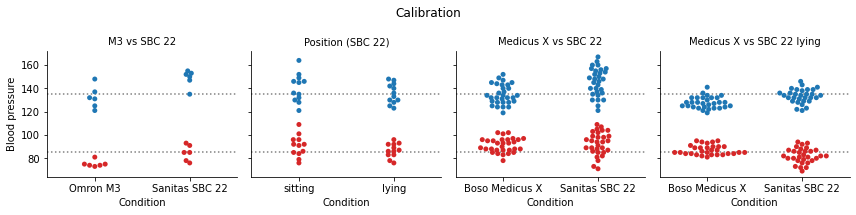

In [6]:
grid = sns.catplot(
    data=calibration_data.melt(
        id_vars=["Calibration", "Condition"],
        value_vars=["Dia", "Sys"],
        var_name="Kind",
        value_name="Blood pressure",
    ),
    x="Condition",
    y="Blood pressure",
    col="Calibration",
    # col_wrap=2,
    hue="Kind",
    palette=["tab:red", "tab:blue"],
    sharex=False,
    kind="swarm",
    height=3,
    legend=False,
)
grid.fig.suptitle("Calibration")
for limit in limits:
    grid.refline(y=limit, linestyle=":")
grid.set_titles("{col_name}")
plt.show()

## Establishing baseline

In [7]:
baseline = blood_pressure.query("Treatment == 'Baseline'").copy()
baseline["Meter"] = (
    baseline["Meter"]
    + " ("
    + baseline["Timestamp"].dt.year.astype(str)
    + ")"
)

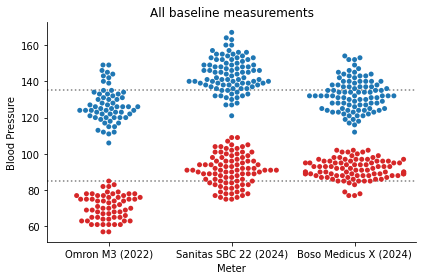

In [8]:
sns.swarmplot(
    data=baseline.melt(
        id_vars=["Meter"],
        value_vars=["Dia", "Sys"],
        var_name="Kind",
        value_name="Blood Pressure",
    ),
    x="Meter",
    y="Blood Pressure",
    hue="Kind",
    palette=["tab:red", "tab:blue"],
)
sns.despine()
plt.title("All baseline measurements")
plt.hlines(limits, *plt.gca().get_xlim(), ls=":", color="0.5")
plt.legend([], frameon=False)
plt.tight_layout()
plt.show()

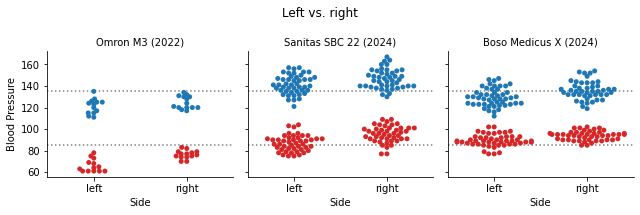

In [9]:
grid = sns.catplot(
    data=baseline.melt(
        id_vars=["Meter", "Side"],
        value_vars=["Dia", "Sys"],
        var_name="Kind",
        value_name="Blood Pressure",
    ),
    x="Side",
    y="Blood Pressure",
    col="Meter",
    hue="Kind",
    palette=["tab:red", "tab:blue"],
    kind="swarm",
    height=3,
    legend=False,
)
grid.fig.suptitle("Left vs. right")
for limit in limits:
    grid.refline(y=limit, linestyle=":")
grid.set_titles("{col_name}")
plt.show()

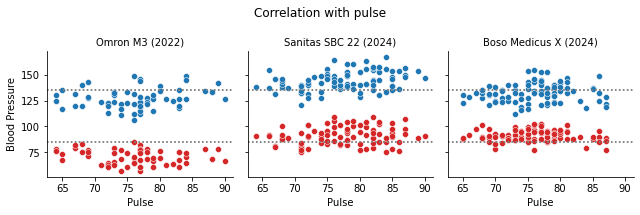

In [10]:
grid = sns.FacetGrid(
    baseline.melt(
        id_vars=["Meter", "Pulse"],
        value_vars=["Dia", "Sys"],
        var_name="Kind",
        value_name="Blood Pressure",
    ),
    col="Meter",
    hue="Kind",
    palette=["tab:red", "tab:blue"],
)
grid.map(sns.scatterplot, "Pulse", "Blood Pressure")
grid.fig.suptitle("Correlation with pulse")
for limit in limits:
    grid.refline(y=limit, linestyle=":")
grid.set_titles("{col_name}")
plt.show()

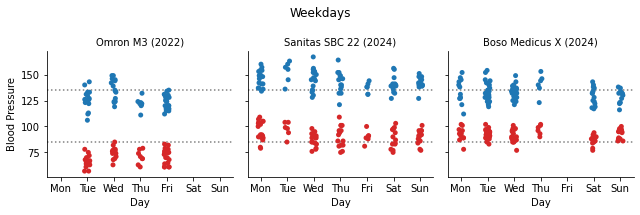

In [11]:
def plot_weekdays(data, col):
    data = data.melt(
        id_vars=["Timestamp", col],
        value_vars=["Dia", "Sys"],
        var_name="Kind",
        value_name="Blood Pressure",
    )
    weekdays = CategoricalDtype(
        ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"], ordered=True
    )
    data["Day"] = data["Timestamp"].dt.day_name().str[:3].astype(weekdays)
    grid = sns.catplot(
        data=data,
        x="Day",
        y="Blood Pressure",
        col=col,
        hue="Kind",
        palette=["tab:red", "tab:blue"],
        height=3,
        col_wrap=3,
        legend=False,
    )
    grid.fig.suptitle("Weekdays")
    for limit in limits:
        grid.refline(y=limit, linestyle=":")
    grid.set_titles("{col_name}")
    plt.show()


plot_weekdays(baseline, "Meter")

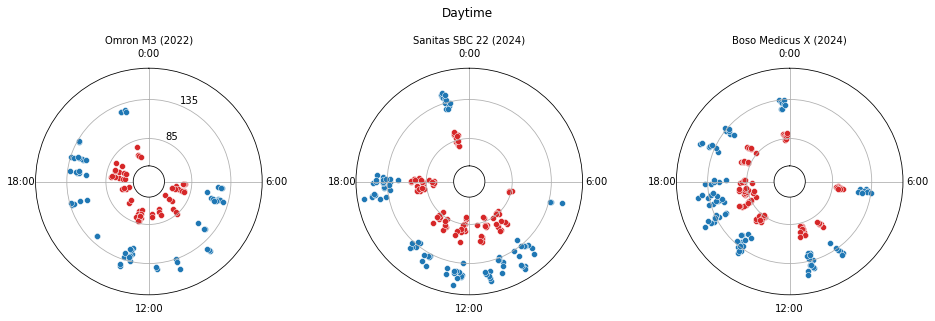

In [12]:
def plot_daytimes(data, col):
    data = data.melt(
        id_vars=["Timestamp", col],
        value_vars=["Dia", "Sys"],
        var_name="Kind",
        value_name="Blood Pressure",
    )
    data["Angle"] = data["Timestamp"].apply(
        lambda dt: (dt.hour * 60 + dt.minute) / (24 * 60) * 2 * np.pi
    )
    grid = sns.FacetGrid(
        data,
        col=col,
        hue="Kind",
        palette=["tab:red", "tab:blue"],
        subplot_kws={"projection": "polar"},
        despine=False,
        height=4.5,
        col_wrap=3,
    )
    grid.map(sns.scatterplot, "Angle", "Blood Pressure")
    grid.fig.suptitle("Daytime")
    grid.set_titles("{col_name}")
    for ax in grid.axes.flatten():
        ax.set_xlabel("")
        ax.set_ylabel("")
        ax.set_theta_zero_location("N")
        ax.set_theta_direction("clockwise")
        ax.set_rlim(50, 175)
        ax.set_rorigin(30)
        ax.set_rticks(limits)
        ax.set_xticks(np.arange(4) * np.pi / 2)
        ax.set_xticklabels(["0:00", "6:00", "12:00", "18:00"])
    plt.tight_layout()
    plt.show()


plot_daytimes(baseline, "Meter")

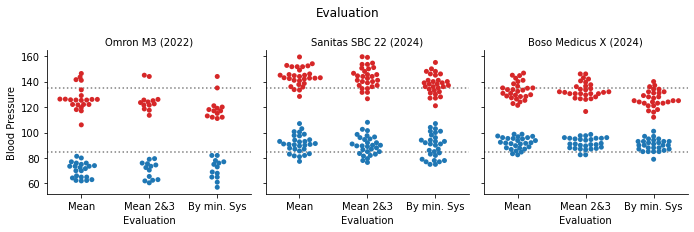

In [13]:
def analyse(replicates):
    """
    According to my general practitioner one takes three measurements and keeps either
    the mean of the 2nd and 3rd measurement or the one with the lowest systole.
    """
    kinds = ["Dia", "Sys", "Pulse"]
    rows = [
        {"Evaluation": "Mean", "Kind": kind, "Value": replicates[kind].mean()}
        for kind in kinds
    ]
    if len(replicates) >= 3:
        replicate_with_min_sys = replicates.loc[replicates["Sys"].iloc[:3].idxmin()]
        rows += [
            {
                "Evaluation": "Mean 2&3",
                "Kind": kind,
                "Value": replicates.iloc[1:3][kind].mean(),
            }
            for kind in kinds
        ] + [
            {
                "Evaluation": "By min. Sys",
                "Kind": kind,
                "Value": replicate_with_min_sys[kind],
            }
            for kind in kinds
        ]

    for row in rows:
        row.update(
            {
                "Timestamp": replicates["Timestamp"].min(),
                "Meter": replicates["Meter"].iloc[0],
                "Side": replicates["Side"].iloc[0],
            }
        )
    return pd.DataFrame(rows)


def evaluate(data):
    eps = pd.to_timedelta("30min")
    measurement = (
        data.sort_values(["Side", "Meter", "Timestamp"])["Timestamp"].diff().abs() > eps
    ).cumsum()
    measurement.name = "Measurement"
    return (
        data.groupby(measurement)
        .apply(analyse)
        .sort_values("Timestamp")
        .reset_index(drop=True)
    )


measurements = (
    evaluate(baseline)
    .query("Kind != 'Pulse'")
    .rename(columns={"Value": "Blood Pressure"})
)
grid = sns.catplot(
    data=measurements,
    x="Evaluation",
    y="Blood Pressure",
    col="Meter",
    hue="Kind",
    palette=["tab:red", "tab:blue"],
    kind="swarm",
    height=3.25,
    legend=False,
)
grid.fig.suptitle("Evaluation")
for limit in limits:
    grid.refline(y=limit, linestyle=":")
grid.set_titles("{col_name}")
plt.show()

## Track treatment

In [14]:
treatments = blood_pressure.query("Meter == 'Boso Medicus X'")

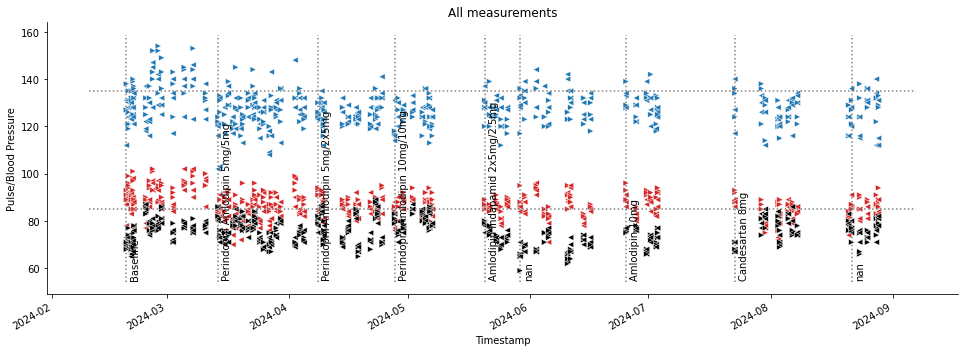

In [15]:
plt.figure(figsize=(13.5, 5))
sns.scatterplot(
    data=treatments.melt(
        id_vars=["Timestamp", "Meter", "Side"],
        value_vars=["Dia", "Sys", "Pulse"],
        var_name="Kind",
        value_name="Pulse/Blood Pressure",
    ),
    x="Timestamp",
    y="Pulse/Blood Pressure",
    hue="Kind",
    palette=["tab:red", "tab:blue", "black"],
    style="Side",
    markers={"left": "<", "right": ">"},
)
sns.despine()
plt.title("All measurements")
plt.legend([], frameon=False)
plt.gcf().autofmt_xdate()
plt.hlines(limits, *plt.gca().get_xlim(), ls=":", color="0.5")
ylim = plt.gca().get_ylim()
for _, treatment in treatments[
    treatments["Treatment"].fillna("None").shift()
    != treatments["Treatment"].fillna("None")
].iterrows():
    plt.vlines(treatment["Timestamp"], *ylim, ls=":", color="0.5")
    plt.gca().text(
        x=treatment["Timestamp"] + pd.to_timedelta("1d"),
        y=56,
        s=treatment["Treatment"],
        rotation="vertical",
    )
plt.tight_layout()
plt.show()

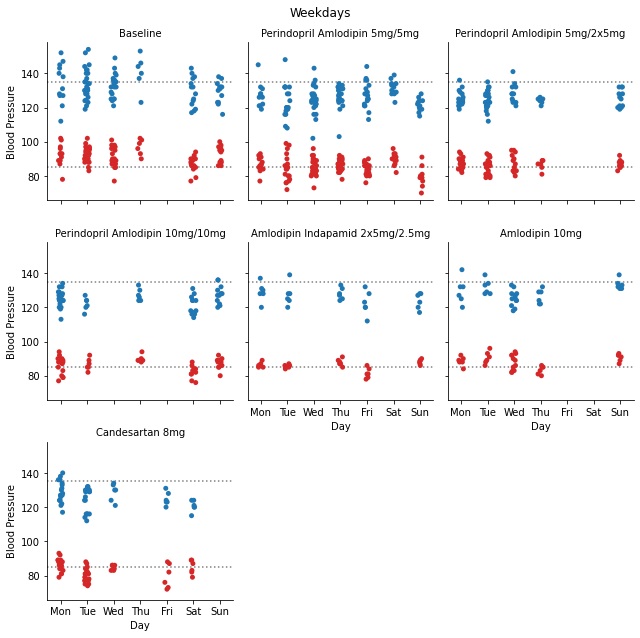

In [16]:
plot_weekdays(treatments, "Treatment")

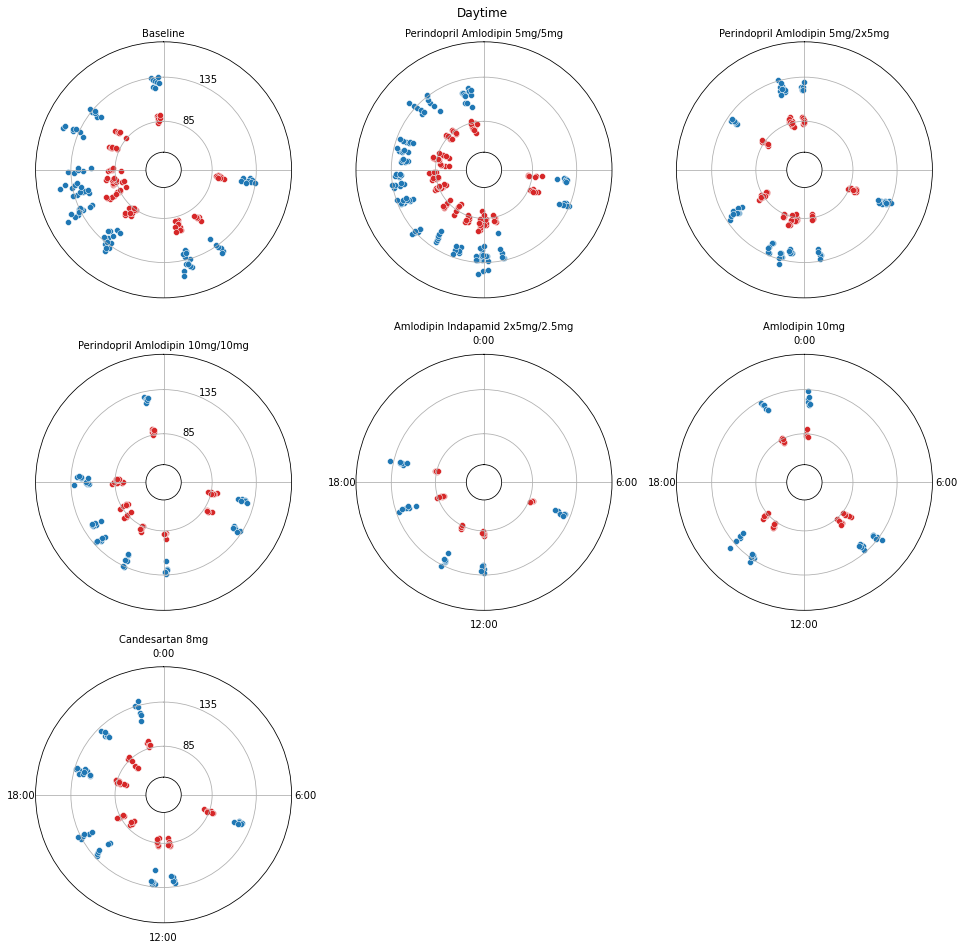

In [17]:
plot_daytimes(treatments, "Treatment")

In [18]:
with pd.ExcelWriter("averaged_blood_pressure.xlsx") as writer:
    for treatment, data in treatments.groupby("Treatment"):
        measurements = evaluate(data)
        measurements.query("Evaluation == 'Mean 2&3'").pivot(
            index=["Timestamp", "Side"], columns="Kind", values="Value"
        )[["Sys", "Dia", "Pulse"]].style.highlight_between(
            subset="Sys", left=135, color="indianred"
        ).highlight_between(
            subset="Dia", left=85, color="indianred"
        ).to_excel(
            writer, sheet_name=treatment.replace("/", "|")
        )